In [23]:
import os
import pandas as pd

# Directory where CSV files are stored
csv_directory = '/Users/aimee/Documents/College/Courses/S24/17-735/17735-project/ExtractedData'

# Lists to hold data from each file
logon_data = []
logoff_data = []

# Iterate over each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Full path to the CSV file
        csv_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path, names=['User', 'Timestamp', 'PC', 'ActivityType', 'Action'])

        # Convert Timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Extract time and hour from Timestamp
        df['Time'] = df['Timestamp'].dt.time
        df['Hour'] = df['Timestamp'].dt.hour

        # Append DataFrame to the list by action
        logon_data.append(df[df['Action'] == 'Logon'])
        logoff_data.append(df[df['Action'] == 'Logoff'])

# Concatenate all logon and logoff data into two separate DataFrames
logon_df = pd.concat(logon_data)
logoff_df = pd.concat(logoff_data)

# Group by 'User' and aggregate times for logon
df_user_logon_stats = logon_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logon_mode = logon_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logon_mean = logon_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logon_mean['Hour'] = df_logon_mean['Hour'].astype(int)
df_logon_mean['Hour'] = pd.to_datetime(df_logon_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logon stats DataFrame
df_user_logon_stats['mode'] = df_logon_mode['Time']
df_user_logon_stats['mean'] = df_logon_mean['Hour']

# Group by 'User' and aggregate times for logoff
df_user_logoff_stats = logoff_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logoff_mode = logoff_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logoff_mean = logoff_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logoff_mean['Hour'] = df_logoff_mean['Hour'].astype(int)
df_logoff_mean['Hour'] = pd.to_datetime(df_logoff_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logoff stats DataFrame
df_user_logoff_stats['mode'] = df_logoff_mode['Time']
df_user_logoff_stats['mean'] = df_logoff_mean['Hour']


In [24]:
df_user_logon_stats

,User,min,max,mode,mean
0,DTAA/AAA0371,07:35:01,13:46:57,07:54:21,09:00:00
1,DTAA/AAC0344,07:50:03,08:09:53,08:06:07,07:00:00
2,DTAA/AAC0599,07:50:03,08:09:58,07:56:28,07:00:00
3,DTAA/AAH0734,08:20:05,08:39:58,08:26:55,08:00:00
4,DTAA/AAK0658,08:20:00,08:39:54,08:25:59,08:00:00
...,...,...,...,...,...
995,DTAA/ZGH0528,08:35:06,14:54:12,08:36:42,10:00:00
996,DTAA/ZKE0662,07:20:03,13:36:39,07:32:54,09:00:00
997,DTAA/ZKH0388,06:35:00,16:35:13,06:39:22,08:00:00
998,DTAA/ZKN0548,08:20:05,08:39:46,08:25:35,08:00:00


In [25]:
df_user_logoff_stats

,User,min,max,mode,mean
0,DTAA/AAA0371,08:33:18,14:54:58,14:48:22,13:00:00
1,DTAA/AAC0344,15:55:00,16:09:58,16:09:07,15:00:00
2,DTAA/AAC0599,15:55:01,16:09:53,16:04:27,15:00:00
3,DTAA/AAH0734,17:25:00,17:39:59,17:34:26,17:00:00
4,DTAA/AAK0658,16:25:05,16:39:59,16:38:32,16:00:00
...,...,...,...,...,...
995,DTAA/ZGH0528,17:40:01,17:54:58,17:50:07,17:00:00
996,DTAA/ZKE0662,19:25:02,19:39:59,19:38:17,19:00:00
997,DTAA/ZKH0388,07:34:06,17:54:59,17:50:09,16:00:00
998,DTAA/ZKN0548,18:25:01,18:39:54,18:32:07,18:00:00


In [28]:
import numpy as np
def dtt2timestamp(dtt):
  time_in_sec = (dtt.hour*60 + dtt.minute) * 60 + dtt.second
  return time_in_sec

df_user_logon_stats_sec = df_user_logon_stats

time_columns = ['min', 'max', 'mode', 'mean']
for col in time_columns:
    df_user_logon_stats_sec[col] = pd.to_datetime(df_user_logon_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['min']]
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mean']]

df_user_logon_stats_sec['min_ts'] = min_ts
df_user_logon_stats_sec['max_ts'] = max_ts
df_user_logon_stats_sec['mode_ts'] = mode_ts
df_user_logon_stats_sec['mean_ts'] = mean_ts


df_user_logon_stats_sec.drop(['min','max','mode','mean'], axis=1)

df_user_logoff_stats_sec = df_user_logoff_stats

for col in time_columns:
    df_user_logoff_stats_sec[col] = pd.to_datetime(df_user_logoff_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['min']] 
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mean']]


df_user_logoff_stats_sec['min_ts'] = min_ts
df_user_logoff_stats_sec['max_ts'] = max_ts
df_user_logoff_stats_sec['mode_ts'] = mode_ts
df_user_logoff_stats_sec['mean_ts'] = mean_ts


df_user_logoff_stats_sec.drop(['min', 'max','mode','mean'], axis=1)


df_log_on_off_stats = pd.DataFrame()

df_log_on_off_stats['User'] = df_user_logon_stats_sec['User']
df_log_on_off_stats['on_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['on_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['on_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['on_mean_ts'] = df_user_logon_stats_sec['mean_ts']
df_log_on_off_stats['off_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['off_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['off_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['off_mean_ts'] = df_user_logon_stats_sec['mean_ts']


#df_log_on_off_stats.dtypes

log_stats = df_log_on_off_stats.drop(['User'], axis=1)
log_stats_array = np.array(log_stats)  # Changed from np.matrix to np.array
print(log_stats)

     on_min_ts  on_max_ts  on_mode_ts  on_mean_ts  off_min_ts  off_max_ts  \
0        27301      49617       28461       32400       27301       49617   
1        28203      29393       29167       25200       28203       29393   
2        28203      29398       28588       25200       28203       29398   
3        30005      31198       30415       28800       30005       31198   
4        30000      31194       30359       28800       30000       31194   
..         ...        ...         ...         ...         ...         ...   
995      30906      53652       31002       36000       30906       53652   
996      26403      48999       27174       32400       26403       48999   
997      23700      59713       23962       28800       23700       59713   
998      30005      31186       30335       28800       30005       31186   
999      32702      33894       33569       32400       32702       33894   

     off_mode_ts  off_mean_ts  
0          28461        32400  
1          

In [44]:
from sklearn.model_selection import train_test_split
# train, test = train_test_split(log_stats_array, test_size=0.2)
train = log_stats_array
test = log_stats_array

In [76]:
import numpy as np
import math

class IsolationForestCustom:
    def __init__(self, n_estimators=100, max_samples='auto', max_depth=1, contamination=0.1, random_state=None, epsilon=0.1):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.contamination = contamination
        self.random_state = random_state
        self.epsilon = epsilon
        self.test_data_size = 0
        self.trees = []

    def fit(self, X):
        num_samples, num_features = X.shape
        self.test_data_size = num_samples
        self.max_samples = self.max_samples if self.max_samples != 'auto' else min(256, num_samples)

        for _ in range(self.n_estimators):
            idx = np.random.choice(num_samples, size=self.max_samples, replace=False)
            tree = self._fit_tree(X[idx], max_depth=self.max_depth)
            self.trees.append(tree)

    def _fit_tree(self, X, max_depth):
        if max_depth <= 0 or len(X) <= 1:
            return {'isLeaf': True,
                    'size': len(X)
            }
        num_samples, num_features = X.shape
        feature_idx = np.random.randint(0, num_features)
        split_val = np.random.uniform(X[:, feature_idx].min(), X[:, feature_idx].max())
        
        left_idxs = X[:, feature_idx] < split_val
        right_idxs = ~left_idxs
        
        left_subtree = self._fit_tree(X[left_idxs], max_depth - 1)
        right_subtree = self._fit_tree(X[right_idxs], max_depth - 1)

        return {
            'isLeaf': False,
            'feature_idx': feature_idx,
            'split_val': split_val,
            'left': left_subtree,
            'right': right_subtree
        }

    def c(self, sample_size):
        if (sample_size < 2):
            return 0
        elif (sample_size == 2):
            return 1
        return 2.0 * (math.log(sample_size - 1) + 0.5772156649) - 2.0 * (sample_size - 1) / self.test_data_size

    def predict(self, X):
        num_samples = len(X)
        anomaly_scores = np.zeros(num_samples)
        
        for i, sample in enumerate(X):
            for j, tree in enumerate(self.trees):
                anomaly_scores[i] += self._path_length(sample, tree)
            anomaly_scores[i] = 2 ** (-anomaly_scores[i] / self.n_estimators / self.c(self.max_samples))

        return anomaly_scores

    def _path_length(self, x, tree):
        current_node = tree  # Start from the root node
        path_length = 0
        
        while True:
            if 'size' in current_node:
                return path_length + self.c(current_node['size'])
            feature_idx = current_node['feature_idx']
            split_val = current_node['split_val']
            
            if x[feature_idx] < split_val:  # Traverse left
                current_node = current_node['left']
            else:  # Traverse right
                current_node = current_node['right']
                    
                    
            path_length += 1

In [77]:
# Example usage:
# Assuming X_train is your training data
iforest_custom = IsolationForestCustom(n_estimators=100, contamination=0.1, epsilon=0.1)
iforest_custom.fit(train)

# Assuming X_test is your test data
# Use the trained model to predict anomaly scores for the test data
anomaly_scores = iforest_custom.predict(test)
print(anomaly_scores)

[0.482283   0.48164748 0.48164748 0.48143606 0.48143606 0.48143606
 0.48322975 0.48253178 0.48690127 0.48164748 0.48225167 0.48648129
 0.48164748 0.51072066 0.50987253 0.48394966 0.48412011 0.48324862
 0.48143606 0.48225167 0.48739595 0.48143606 0.48143606 0.48324862
 0.51161933 0.4836136  0.4845773  0.48312511 0.51228273 0.48143606
 0.48648129 0.48164748 0.48324862 0.51026299 0.48164748 0.48164748
 0.48862777 0.51573528 0.48164748 0.48648129 0.51267699 0.49062491
 0.48466632 0.48324862 0.48665154 0.51075775 0.48322975 0.48547014
 0.50820641 0.50987253 0.48143606 0.50189724 0.48648129 0.48181364
 0.49123763 0.51573528 0.51573528 0.48322975 0.4845773  0.48143606
 0.48648129 0.48164748 0.48322975 0.48813107 0.54304416 0.51364091
 0.4880811  0.48225167 0.48164748 0.48317161 0.48322975 0.48164748
 0.482283   0.48862777 0.48648129 0.48225167 0.48164748 0.48164748
 0.48269824 0.48225167 0.48739595 0.493548   0.48164748 0.48143606
 0.48272418 0.482283   0.48164748 0.48143606 0.48164748 0.4839

In [67]:
anomaly_count = 0
norm_count = 0
for score in anomaly_scores:
    if score > 0.5:
        anomaly_count += 1
    else:
        norm_count += 1

In [68]:
anomaly_count

141

In [69]:
norm_count

859

In [71]:
log_ascore = anomaly_scores

df_user_log_result = pd.DataFrame()
df_user_log_result['User'] = df_user_logoff_stats_sec['User']
df_user_log_result['anomaly_score'] = log_ascore
# df_user_log_result.to_csv('user_log_result.csv')
print(df_user_log_result)


outliers = df_user_log_result.loc[df_user_log_result['anomaly_score'] > 0.5]
print(outliers)

             User  anomaly_score
0    DTAA/AAA0371       0.482131
1    DTAA/AAC0344       0.480183
2    DTAA/AAC0599       0.480183
3    DTAA/AAH0734       0.479877
4    DTAA/AAK0658       0.479877
..            ...            ...
995  DTAA/ZGH0528       0.491176
996  DTAA/ZKE0662       0.483500
997  DTAA/ZKH0388       0.487292
998  DTAA/ZKN0548       0.479877
999  DTAA/ZRR0705       0.493407

[1000 rows x 2 columns]
             User  anomaly_score
13   DTAA/ABS0726       0.509329
24   DTAA/AFF0760       0.514187
28   DTAA/AFO0022       0.513792
33   DTAA/AGW0182       0.509852
37   DTAA/AIB0797       0.522312
..            ...            ...
970  DTAA/WTA0867       0.512573
972  DTAA/XCB0445       0.512573
975  DTAA/XIN0791       0.508041
987  DTAA/YQW0689       0.510343
990  DTAA/ZAB0889       0.506698

[141 rows x 2 columns]


In [72]:
# Lists to hold data from each file
connect_data = []
disconnect_data = []

# Iterate over each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Full path to the CSV file
        csv_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path, names=['User', 'Timestamp', 'PC', 'ActivityType', 'Action'])

        # Convert Timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Filter DataFrame by action and append to the respective list
        connect_data.append(df[df['Action'] == 'Connect'])
        disconnect_data.append(df[df['Action'] == 'Disconnect'])

# Concatenate all connect and disconnect data into two separate DataFrames
connect_df = pd.concat(connect_data)
disconnect_df = pd.concat(disconnect_data)

# Function to format datetime as H:M:S
format_time = lambda x: x.strftime('%H:%M:%S')

# Calculate means for connect and disconnect
connect_means = connect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))
disconnect_means = disconnect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))

# Calculate modes for connect and disconnect
# We use scipy's mode function which returns the first mode in case of multimodal data
connect_modes = connect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))
disconnect_modes = disconnect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))

# Convert Series to DataFrame for CSV output
connect_means_df = connect_means.reset_index().rename(columns={'Timestamp': 'Connect_mean_time'})
connect_modes_df = connect_modes.reset_index().rename(columns={'Timestamp': 'Connect_mode_time'})

disconnect_means_df = disconnect_means.reset_index().rename(columns={'Timestamp': 'Disconnect_mean_time'})
disconnect_modes_df = disconnect_modes.reset_index().rename(columns={'Timestamp': 'Disconnect_mode_time'})

# Create stats DataFrame for connection data
df_device_conn_stats = connect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time.apply(format_time)
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time.apply(format_time)
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time'}, inplace=True)

# These variables hold the respective statistics for later use in your code:
# connect_means_df, connect_modes_df, disconnect_means_df, disconnect_modes_df

In [73]:
# Create stats DataFrame for connection data
df_device_conn_stats = connect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time',
                                     'Connect_mean_time': 'Connect_mean_time',
                                     'Connect_mode_time': 'Connect_mode_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time',
                                        'Disconnect_mean_time': 'Disconnect_mean_time',
                                        'Disconnect_mode_time': 'Disconnect_mode_time'}, inplace=True)

In [74]:
# Conversion of connection times to timestamps in seconds
for col in ['Connect_min_time', 'Connect_max_time', 'Connect_mode_time', 'Connect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_conn_stats[col + '_ts'] = pd.to_datetime(df_device_conn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_conn_stats[col + '_sec'] = df_device_conn_stats[col + '_ts'].apply(dtt2timestamp)

# Conversion of disconnection times to timestamps in seconds
for col in ['Disconnect_min_time', 'Disconnect_max_time', 'Disconnect_mode_time', 'Disconnect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_disconn_stats[col + '_ts'] = pd.to_datetime(df_device_disconn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_disconn_stats[col + '_sec'] = df_device_disconn_stats[col + '_ts'].apply(dtt2timestamp)

# Merge the connection and disconnection dataframes
df_device_full = pd.merge(df_device_conn_stats, df_device_disconn_stats, on='User')

# Select columns that end with '_sec' for analysis
sec_columns = [col for col in df_device_full.columns if col.endswith('_sec')]
device_full_array = df_device_full[sec_columns].values

In [82]:

train = device_full_array
test = device_full_array

# Example usage:
iforest_custom = IsolationForestCustom(n_estimators=100, contamination=0.1, epsilon=0.1)
iforest_custom.fit(train)

# Use the trained model to predict anomaly scores for the test data
df_device_full['anomaly_score'] = iforest_custom.predict(test)

df_device_full_outliers = df_device_full[df_device_full['anomaly_score'] > 0.5]
print(df_device_full_outliers)

             User Connect_min_time Connect_max_time Connect_mean_time  \
109  DTAA/JBL0450         00:36:02         00:13:17          21:42:22   
142  DTAA/LKY0181         21:29:42         23:55:31          03:24:15   

    Connect_mode_time Connect_min_time_ts  Connect_min_time_sec  \
109          00:05:11            00:36:02                  2162   
142          02:57:15            21:29:42                 77382   

    Connect_max_time_ts  Connect_max_time_sec Connect_mode_time_ts  ...  \
109            00:13:17                   797             00:05:11  ...   
142            23:55:31                 86131             02:57:15  ...   

     Disconnect_mode_time Disconnect_min_time_ts  Disconnect_min_time_sec  \
109              00:14:56               00:38:35                     2315   
142              00:04:44               22:11:41                    79901   

    Disconnect_max_time_ts Disconnect_max_time_sec Disconnect_mode_time_ts  \
109               00:17:15                

In [83]:
df_all = pd.DataFrame()

# Read all CSV files and concatenate into a single DataFrame
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_directory, filename)
        df_temp = pd.read_csv(file_path, header=None)  # Assuming the CSV has no header
        df_temp.columns = ['User', 'Timestamp', 'PC', 'Activity', 'Action']  # Assign column names
        df_all = pd.concat([df_all, df_temp])

# Ensure 'Timestamp' is a datetime object
df_all['Timestamp'] = pd.to_datetime(df_all['Timestamp'], format='%m/%d/%Y %H:%M:%S')

# Filter out 'Logon' and 'Logoff' activities into separate DataFrames
df_logon = df_all[df_all['Action'] == 'Logon']
df_logoff = df_all[df_all['Action'] == 'Logoff']

# Define a function to perform the aggregation and transformation
def aggregate_user_pc_log_activities(df_activity):
    # Aggregate data to count the total number of activities per user per PC
    df_user_pc = df_activity.groupby(['User', 'PC']).size().reset_index(name='pc_activities_per_user_total')

    # Calculate the unique count of PCs per user
    df_user_pc['unique_pc_count'] = df_user_pc.groupby('User')['PC'].transform('nunique')

    # Keep only the 'User' and 'unique_pc_count' columns and drop duplicates
    df_user_pc = df_user_pc[['User', 'unique_pc_count']].drop_duplicates()

    return df_user_pc

# Apply the function to both logon and logoff DataFrames
df_user_pc_logon = aggregate_user_pc_log_activities(df_logon)
df_user_pc_logoff = aggregate_user_pc_log_activities(df_logoff)

# Optionally, save these dataframes to CSV
# df_user_pc_logon.to_csv('user_pc_logon.csv', index=False)
# df_user_pc_logoff.to_csv('user_pc_logoff.csv', index=False)

In [ ]:
pc_counts = np.array(df_user_pc_logon['unique_pc_count']).reshape(-1, 1)

train = pc_counts
test = pc_counts

# Example usage:
iforest_custom = IsolationForestCustom(n_estimators=100, contamination=0.1, epsilon=0.1)
iforest_custom.fit(train)

anomaly_scores = iforest_custom.predict(test)

In [84]:
import pickle

# Serialize the model using pickle
with open('user_pc_ct_isolation_forest.pkl', 'wb') as file:
    pickle.dump(iforest_custom, file)

# Create a DataFrame to hold the results
results = pd.DataFrame()
results['user'] = df_user_pc_logon['User']
results['unique_pc_count'] = df_user_pc_logon['unique_pc_count']
results['anomaly_score'] = anomaly_scores

# Identify potential outliers
# Outliers are defined as observations with an anomaly score less than 0
df_unique_pc_outliers = results.loc[results['anomaly_score'] > 0.5]

# Display the results
print(results.head(10))  # Show the first 10 results
print(df_unique_pc_outliers)          # Show the outliers

             user  unique_pc_count  anomaly_score
0    DTAA/AAA0371               16       0.482283
16   DTAA/AAC0344                1       0.481647
17   DTAA/AAC0599                1       0.481647
18   DTAA/AAH0734                1       0.481436
19   DTAA/AAK0658                1       0.481436
20   DTAA/AAK0924                1       0.481436
21   DTAA/AAR0508                1       0.483230
22   DTAA/AAS0709               19       0.482532
41   DTAA/ABB0272               72       0.486901
113  DTAA/ABD0833                1       0.481647
               user  unique_pc_count  anomaly_score
117    DTAA/ABS0726               11       0.510721
128    DTAA/ACD0647                1       0.509873
184    DTAA/AFF0760                2       0.511619
291    DTAA/AFO0022               25       0.512283
320    DTAA/AGW0182               65       0.510263
...             ...              ...            ...
21984  DTAA/XIN0791                1       0.511486
22059  DTAA/YCD0922               

In [85]:
df_user_log_result.head()

df_threat_users_log = df_user_log_result.loc[df_user_log_result['anomaly_score'] >= 0.54]
print(df_threat_users_log)

             User  anomaly_score
90   DTAA/ARS0993       0.551570
217  DTAA/CLN0999       0.557260
231  DTAA/CRC0996       0.551570
294  DTAA/DSM0990       0.551570
326  DTAA/ELD1000       0.551570
368  DTAA/GML0105       0.540580
374  DTAA/GRS0372       0.554470
459  DTAA/JCC0998       0.553135
520  DTAA/KEE0997       0.551570
778  DTAA/RBC0583       0.548337


             User Connect_min_time Connect_max_time Connect_mean_time  \
109  DTAA/JBL0450         00:36:02         00:13:17          21:42:22   
142  DTAA/LKY0181         21:29:42         23:55:31          03:24:15   

    Connect_mode_time Connect_min_time_ts  Connect_min_time_sec  \
109          00:05:11            00:36:02                  2162   
142          02:57:15            21:29:42                 77382   

    Connect_max_time_ts  Connect_max_time_sec Connect_mode_time_ts  ...  \
109            00:13:17                   797             00:05:11  ...   
142            23:55:31                 86131             02:57:15  ...   

     Disconnect_mode_time Disconnect_min_time_ts  Disconnect_min_time_sec  \
109              00:14:56               00:38:35                     2315   
142              00:04:44               22:11:41                    79901   

    Disconnect_max_time_ts Disconnect_max_time_sec Disconnect_mode_time_ts  \
109               00:17:15                

,User,Connect_min_time,Connect_max_time,Connect_mean_time,Connect_mode_time,Connect_min_time_ts,Connect_min_time_sec,Connect_max_time_ts,Connect_max_time_sec,Connect_mode_time_ts,...,Disconnect_mode_time,Disconnect_min_time_ts,Disconnect_min_time_sec,Disconnect_max_time_ts,Disconnect_max_time_sec,Disconnect_mode_time_ts,Disconnect_mode_time_sec,Disconnect_mean_time_ts,Disconnect_mean_time_sec,anomaly_score
109,DTAA/JBL0450,00:36:02,00:13:17,21:42:22,00:05:11,00:36:02,2162,00:13:17,797,00:05:11,...,00:14:56,00:38:35,2315,00:17:15,1035,00:14:56,896,21:44:30,78270,0.500738
142,DTAA/LKY0181,21:29:42,23:55:31,03:24:15,02:57:15,21:29:42,77382,23:55:31,86131,02:57:15,...,00:04:44,22:11:41,79901,00:04:44,284,00:04:44,284,07:19:08,26348,0.502667


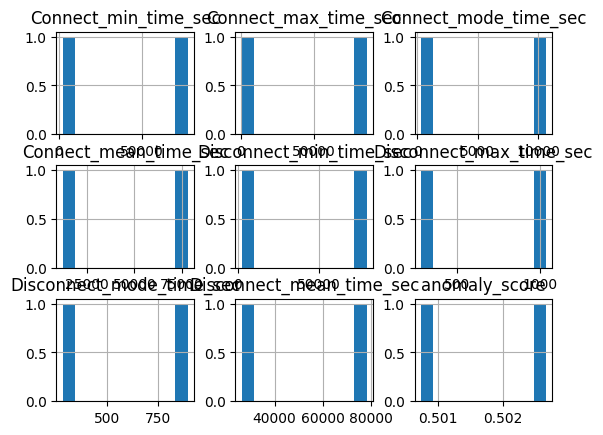

In [86]:
df_device_full_outliers.head()


df_device_full_outliers.loc[df_device_full_outliers['anomaly_score'] > 0.5].hist()

df_threat_users_device_file = df_device_full_outliers.loc[df_device_full_outliers['anomaly_score'] >= 0.5]
print(df_threat_users_device_file)

df_device_full[df_device_full.User.isin(df_threat_users_device_file.User)]

               user  unique_pc_count  anomaly_score
117    DTAA/ABS0726               11       0.510721
128    DTAA/ACD0647                1       0.509873
184    DTAA/AFF0760                2       0.511619
291    DTAA/AFO0022               25       0.512283
320    DTAA/AGW0182               65       0.510263
...             ...              ...            ...
21984  DTAA/XIN0791                1       0.511486
22059  DTAA/YCD0922                1       0.500009
22121  DTAA/YQW0689               51       0.509747
22239  DTAA/ZAB0889                1       0.510377
22241  DTAA/ZBM0626                1       0.501826

[176 rows x 3 columns]


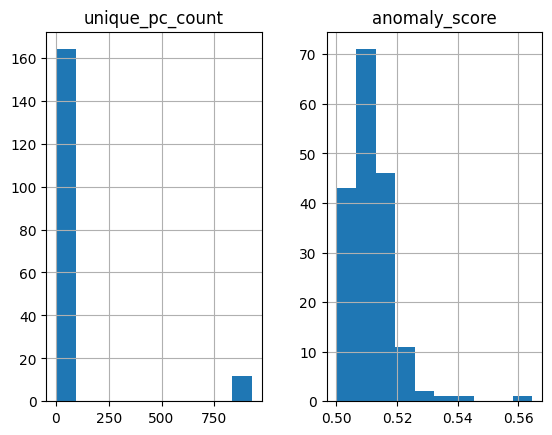

In [87]:


df_unique_pc_outliers.loc[df_unique_pc_outliers['anomaly_score'] > 0.5].hist()

df_threat_users_unique_pc = df_unique_pc_outliers.loc[df_unique_pc_outliers['anomaly_score'] >= 0.5]
print(df_threat_users_unique_pc)